In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from time import time
from icecream import ic

from msfm import grid_pipeline
from msfm.utils import tfrecords, survey
from msfm.utils.input_output import read_yaml

In [10]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

repo_dir = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model"
tfr_pattern = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v2/DESy3_grid_???.tfrecord"

n_z_bins = 4
batch_size = 16
examples_shuffle_buffer = 10
n_readers = 1
n_prefetch = 3

In [11]:
dset = grid_pipeline.get_grid_dset(conf, repo_dir, tfr_pattern, batch_size, i_noise=0, n_readers=n_readers, n_prefetch=n_prefetch)

23-02-20 10:04:46 grid_pipelin INF   Starting to generate the grid data set for i_noise = 0 
23-02-20 10:04:46    survey.py INF   Loaded pixel file 
23-02-20 10:04:46    survey.py INF   Loaded pixel file 
23-02-20 10:04:47 grid_pipelin WAR   Tracing dset_add_bias 
23-02-20 10:04:47 grid_pipelin WAR   Tracing dset_add_noise 
23-02-20 10:04:47 grid_pipelin INF   Successfully generated the fiducial training set with element_spec (TensorSpec(shape=(None, 463872, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))) for i_noise = 0 


In [16]:
for kg, cosmo, index in dset.take(1):
    # print(kg, cosmo, index)
    print(kg.shape, cosmo.shape, len(index))

(16, 463872, 4) (16, 7) 2


# plotting

In [18]:
pix_file = "../../data/DESY3_pixels_512.h5"
with h5py.File(pix_file, "r") as f:
    data_vec_pix = f["metacal/map_cut_outs/data_vec_ids"][:]
    non_tomo_patches_pix = f["metacal/masks/RING/non_tomo"][:]
    
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

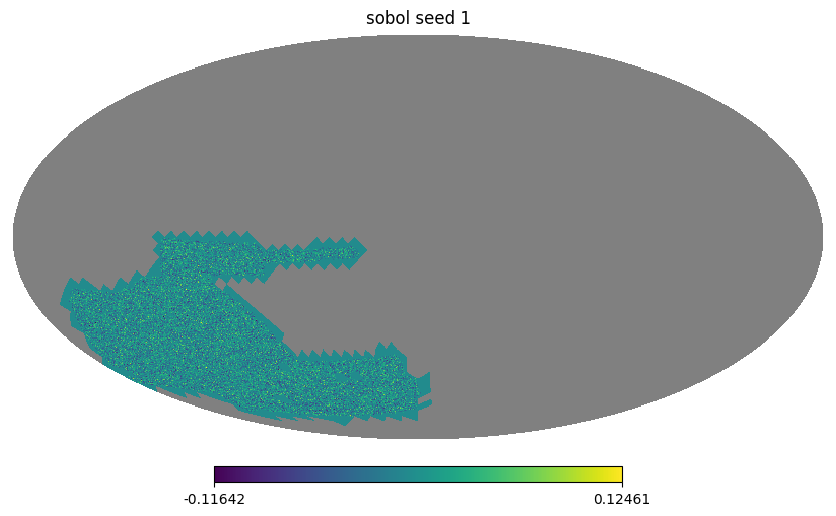

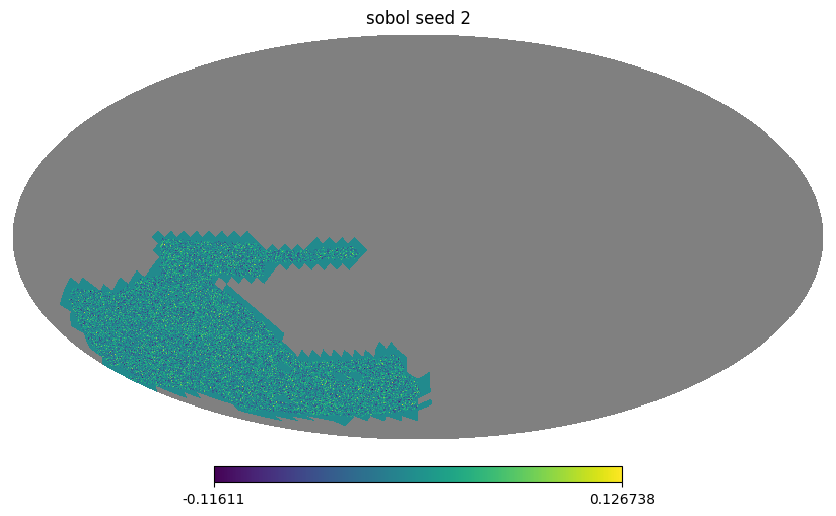

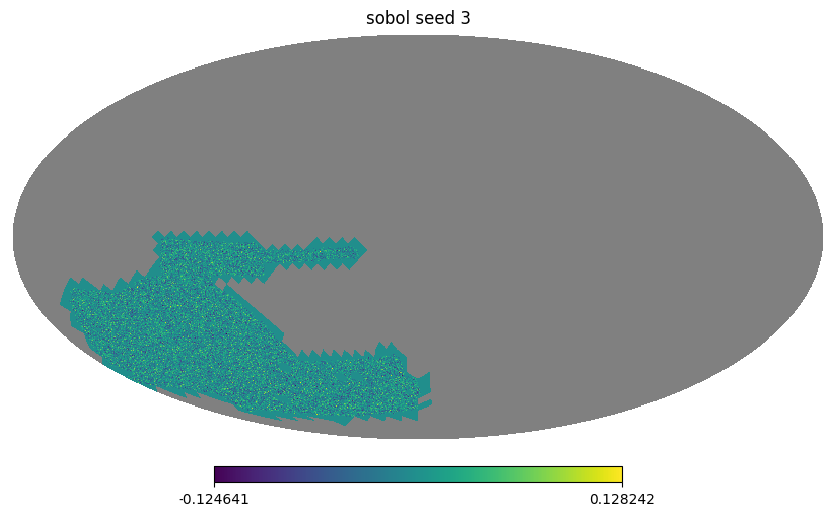

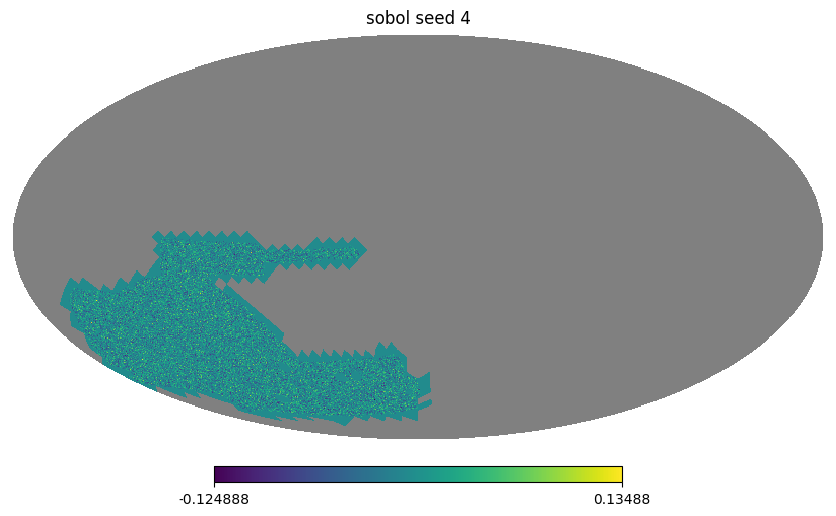

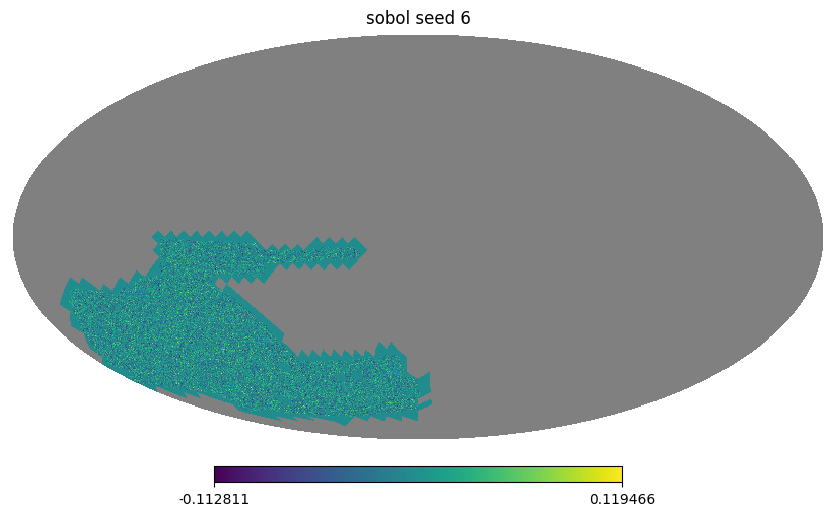

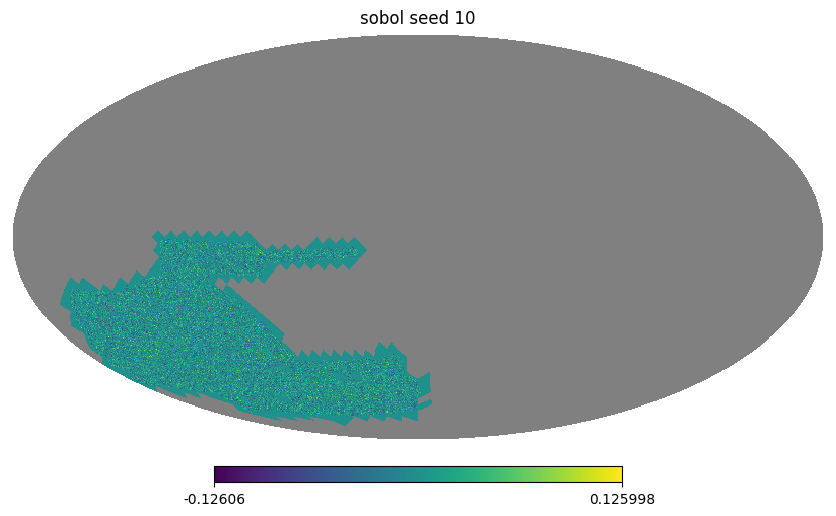

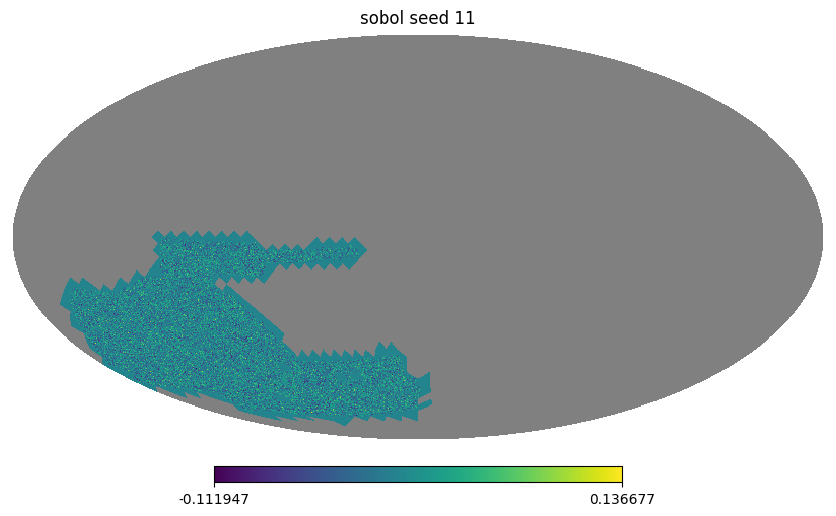

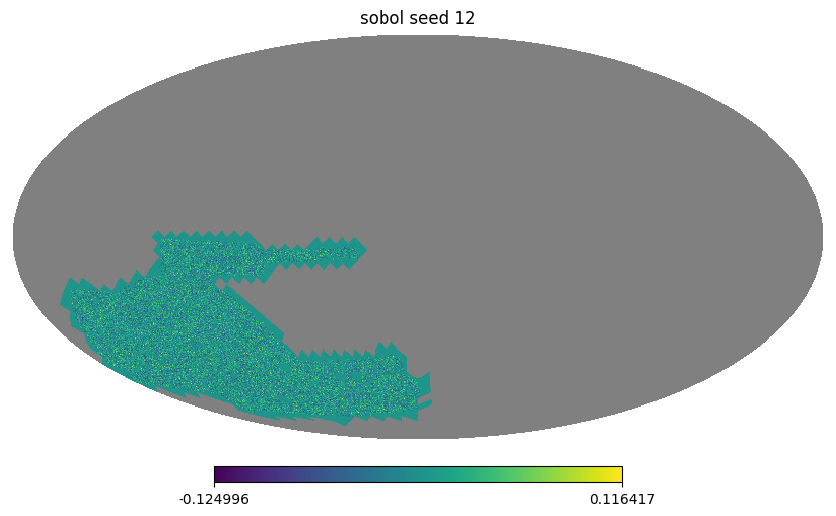

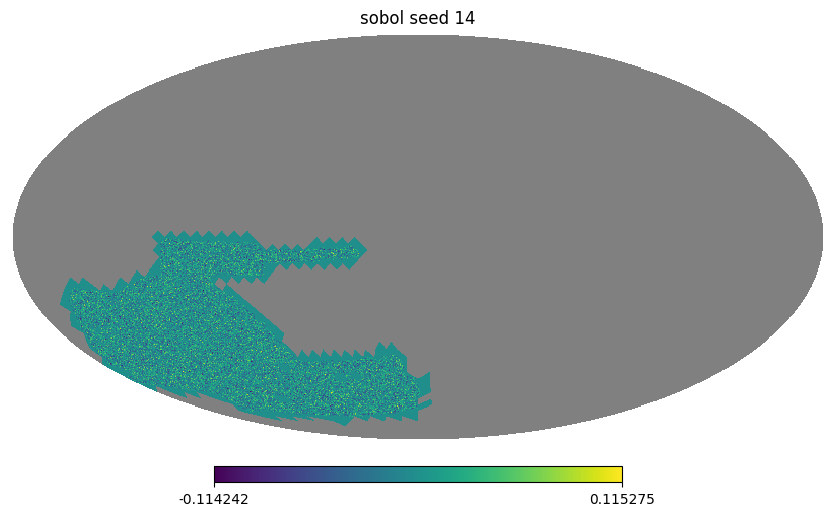

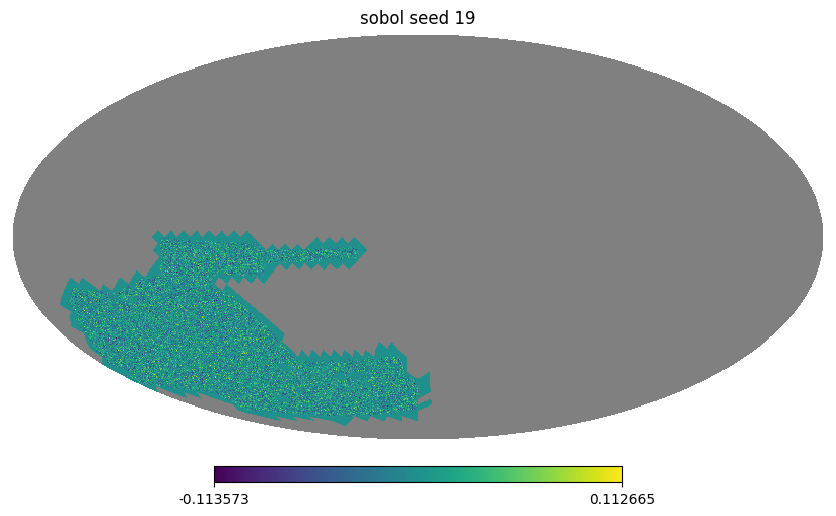

In [21]:
i_tomo = 0
i_batch = 0

for kg, cosmo, index in dset.take(10):
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] =kg.numpy()[i_batch,:,i_tomo]
    hp.mollview(hp_map, nest=True, title=f"sobol seed {index[0][i_batch]}")
